In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#default_exp search

In [3]:
#export
from food.tools import *
from food.paths import *
from food.psql import *
import requests
from food.qdrant import *
import torch
from torch.nn import CosineSimilarity
cos = CosineSimilarity(dim=1, eps=1e-08)
import numpy as np

In [4]:
#export
## temp while api is not aperational
# from food.clipmodel import *
from PIL import Image

In [5]:
# #export
# foods = read_sql('foods')
# # foods = foods.drop(columns = ['clip'])
# foods = foods.set_index('id')

In [6]:
#export
collection_name = 'food_images'
table = 'foods_prompted'
foods = read_sql(table)
foods = foods.set_index('id')

In [7]:
#export
def read_image_from_url(url=None,path=None):
    if url: response = requests.get(url, stream=True)
    if path: pass
    return Image.open(response.raw)



In [8]:
#export
def search_image_(url=None,head = 1,env='dev'):
    client = dev_client if env == 'dev' else prod_client
    image_clip = requests.post(f'https://guru.skynet.center/image2vector/?url={url}').json()
    results = client.search(collection_name=collection_name,query_vector=image_clip,top=head)
    image_clip = torch.Tensor(image_clip)
    df = foods.loc[[r.id for r in results]].copy()
    df['score'] = [r.score for r in results]
    df = df.sort_values('score',ascending=False)

    return image_clip,df.reset_index()

series2tensor = lambda series:torch.tensor([np.array(c) for c in series.values])

In [9]:
#export
drop_vector =      lambda clip, i: torch.cat([clip[0:i], clip[i+1:]])

def multiply_vector(clip,i,n=1):
    duplicated = torch.cat([clip[i].reshape(1,768) for _ in range(n)])
    return torch.cat([clip, duplicated.reshape(n,768)])

In [10]:
#export
def multiple_foods(url,env='dev'):

    image_clip,selected = search_image_(url,head=100,env=env)
    selected=selected.reset_index(drop=True)
    clip = series2tensor(selected['clip'])
    initscore = float(cos(image_clip.reshape(1,768), clip.mean(0).reshape(1,768)).detach().clone())
    startscore = initscore-0.0000001
    n=0

    while startscore !=initscore:
        startscore = initscore
        
        selected = selected.reset_index(drop=True)
        for i in reversed(selected.index):
            clip = series2tensor(selected['clip'])
            dropped = drop_vector(clip,i)
            testscore = float(cos(image_clip.reshape(1,768), dropped.mean(0).reshape(1,768)).detach().clone())

            if testscore > initscore-0.0001: 
                r = selected.loc[i,'text']
                selected = selected.drop(i)
                initscore = testscore

            else:
                extra = multiply_vector(clip,i,1)
                testscore = float(cos(image_clip.reshape(1,768), extra.mean(0).reshape(1,768)).detach().clone())
                if testscore > initscore: 
                    selected = selected.append(selected.loc[i])
                    initscore = testscore

            n+=1
            if n ==15:break

        print(initscore)
    count = selected.groupby('text')['clip'].count().sort_index()
    r = selected.drop_duplicates('text').set_index("text").sort_index()
    r['count'] = count
    r = r.sort_values('count',ascending = False)
    r['share'] = r['count'].cumsum()/r['count'].sum()

    description = '. '.join(r[r['share']<0.9]['description'].unique().tolist())


    return r.drop(columns = ['clip']), description, selected,initscore
    

In [19]:
#export
def search_image(url,env='dev'):
    r, desc, sel,score = multiple_foods(url,env=env)
    df = sel[['energy','protein','carb','fat','score']].mean().to_frame().T
    df['score'] =score
    df['description'] = desc
    return df


In [20]:
url = 'https://glovo.away.guru/test_photos/3fbd4cbe-478a-4482-99e2-43588541e950.jpeg'

In [21]:
url = 'https://image.shutterstock.com/image-photo/pav-bhaji-fast-food-dish-600w-396535507.jpg'

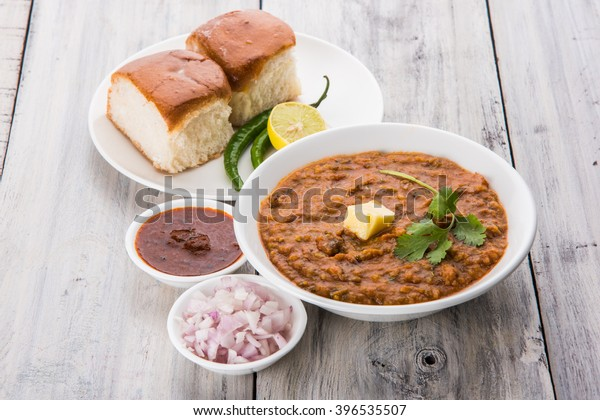

In [22]:
get_image_from_url(url)

In [23]:
search_image(url,env='prod')

0.21046967225801155
0.23686101450499253
0.2516633625900547
0.25201696161602327
0.2521275058450581
0.2521275058450581


,energy,protein,carb,fat,score,description
0,208.4,12.113,31.735,3.781,0.252128,"Papad, grilled or broiled. Lamb or mutton stew..."


In [24]:
!nbdev_build_lib

Converted 00_clipmodel.ipynb.
Converted 00_custom_pandas.ipynb.
Converted 00_paths.ipynb.
Converted 00_progress_check.ipynb.
Converted 00_psql.ipynb.
Converted 00_qdrant.ipynb.
Converted 00_tools.ipynb.
Converted 01_multiple_foods.ipynb.
Converted 01_multiple_foods_segmantation.ipynb.
Converted 01_search.ipynb.
Converted 0_template copy 2.ipynb.
Converted 0_template copy.ipynb.
Converted 0_template.ipynb.
Converted aiogram_bot.ipynb.
Converted classifying_glovo_images.ipynb.
Converted inference.ipynb.
Converted stats.ipynb.
Converted testset_exploration.ipynb.
Converted usda_parsing.ipynb.
